# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


# Step1

## I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(5,8,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Calculate distortion coefficients, and test undistortion on an image!

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('../output_images/calibration1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

Text(0.5,1,'Undistorted Image')

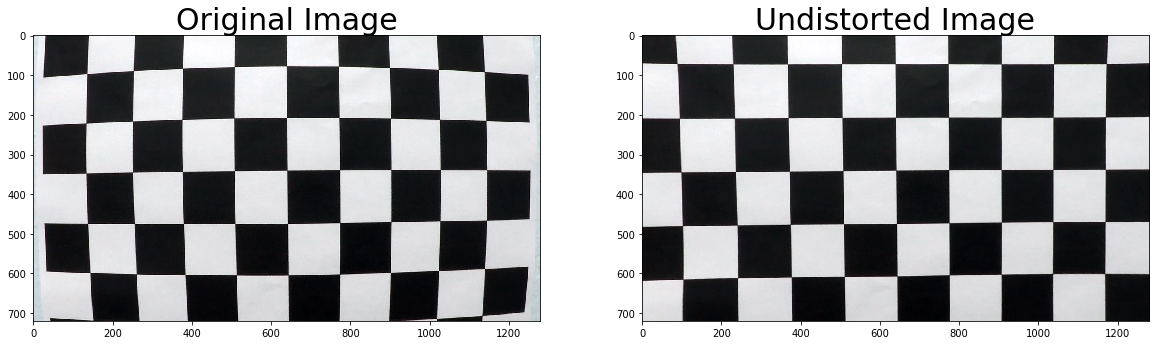

In [3]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Step2 

## Apply a distortion correction to raw images.

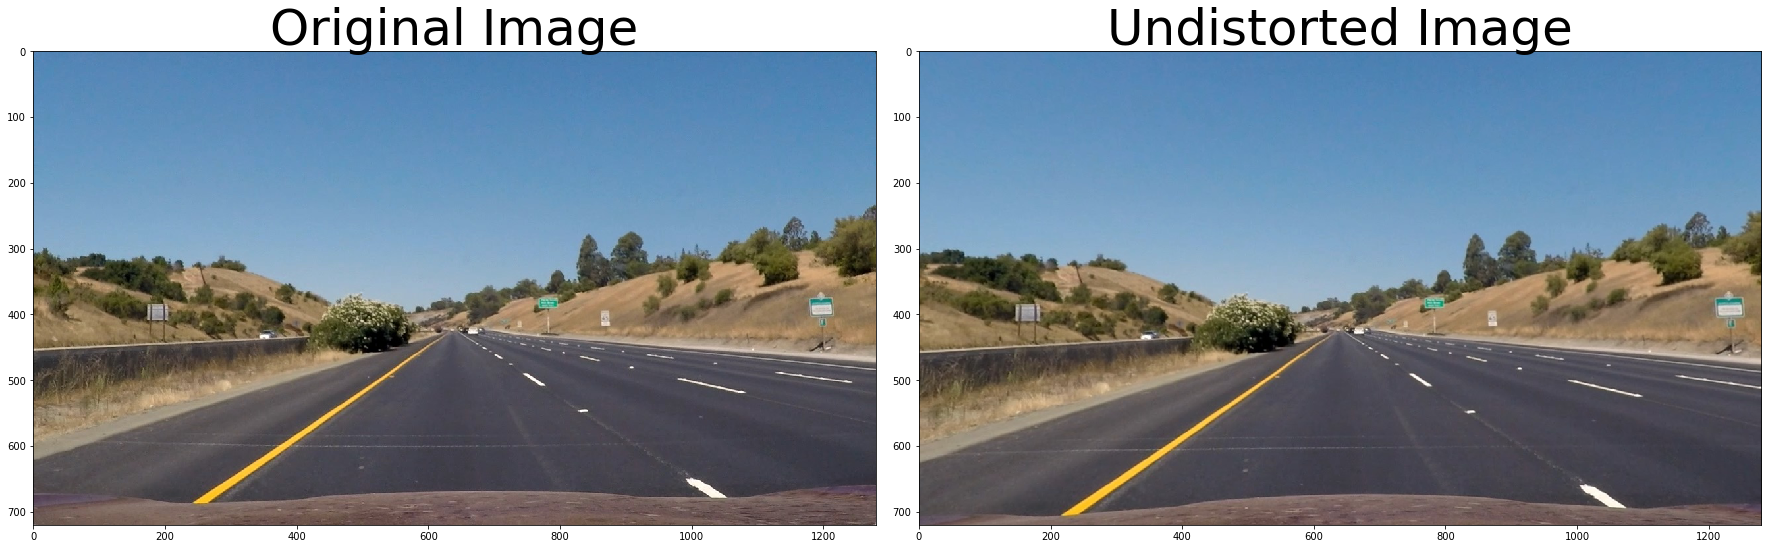

In [10]:
dist_pickle = pickle.load( open( "../camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
image = cv2.imread('../test_images/straight_lines1.jpg')
image_trans = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, mtx, dist):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    #ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    return undist

undistorted = cal_undistort(image, mtx, dist)
raw_undistorted = cv2.cvtColor(undistorted,cv2.COLOR_RGB2BGR)
cv2.imwrite('../output_images/raw_undistorted.jpg',raw_undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_trans)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Step3

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [11]:
def abs_sobel_thresh(img, orient, sobel_kernel = 3, thresh=(0,255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    if orient == 'x':
    # Sobel x
        sobel = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel) # Take the derivative in x
    else:
    # Sobel y
        sobel = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel) # Take the derivative in y    
    abs_sobel = np.absolute(sobel) # Absolute x/y derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def dir_threshold(img,sobel_kernel=3,thresh = (0,np.pi/2)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    sobelx = cv2.Sobel(l_channel,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(l_channel,cv2.CV_64F,0,1,ksize=sobel_kernel)   
    direction = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    binary_output = np.zeros_like(direction)
    binary_output[(direction>=thresh[0])&(direction<=thresh[1])] = 1
    return binary_output  

def color(img, s_thresh=(170,255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel>=s_thresh[0])&(s_channel<=s_thresh[1])]=1
    return s_binary

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

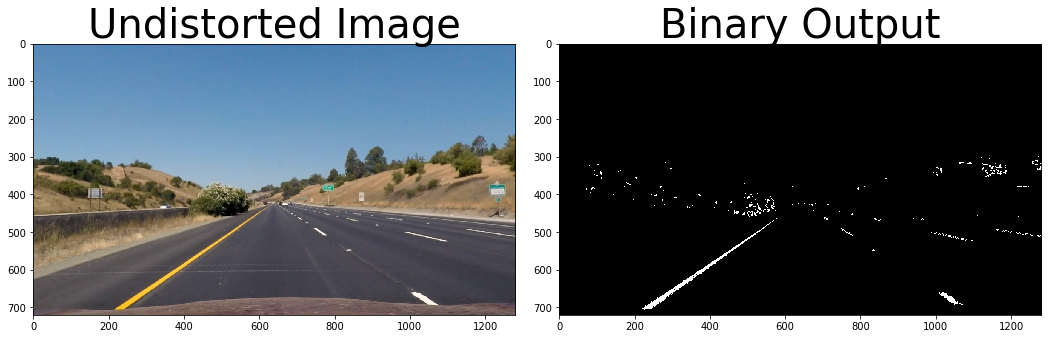

In [12]:
# Parameters need to be tuned
imshape = undistorted.shape
vertices = np.array([[(0,imshape[0]),(int(0.45*imshape[1]),int(0.6*imshape[0])),
                      (int(0.6*imshape[1]),int(0.6*imshape[0])), (imshape[1],imshape[0])]], dtype=np.int32)

#undistorted_mask = region_of_interest(undistorted,vertices)
undistorted_mask = undistorted
ksize = 3
gradx = abs_sobel_thresh(undistorted_mask, 'x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(undistorted_mask, 'y', sobel_kernel=ksize, thresh=(120, 200))
dir_binary = dir_threshold(undistorted_mask, sobel_kernel=15, thresh=(0, 1.5))
color_binary = color(undistorted_mask,s_thresh=(160,255))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((color_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
f.tight_layout()
ax1.imshow(undistorted_mask)
ax1.set_title('Undistorted Image', fontsize=40)
ax2.imshow(combined,cmap='gray')
ax2.set_title('Binary Output', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Step 4
## Apply a perspective transform to rectify binary image ("birds-eye view")

In [13]:
def corners_unwarp(img, src, dst):
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_size = (img.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, M_inv


In [14]:
img_size = (image.shape[1],image.shape[0])
src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 40, img_size[1]],
    [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
top_down, perspective_M, perspective_M_inv = corners_unwarp(image, src, dst)

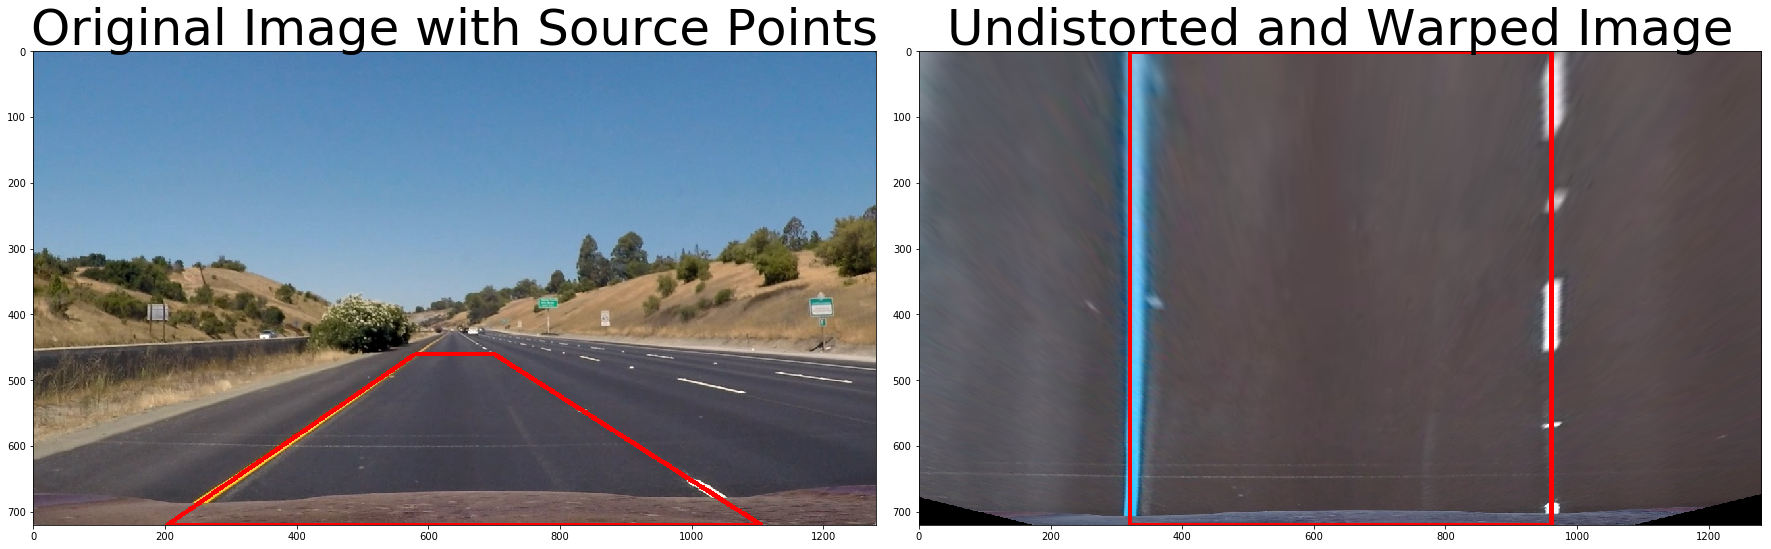

In [15]:

src = src.astype(int).reshape((-1,1,2))
dst = dst.astype(int).reshape((-1,1,2))
image_copy = np.copy(image_trans)
top_down_copy = np.copy(top_down)
cv2.polylines(image_copy,[src],True,(255,0,0),thickness = 5)
cv2.polylines(top_down_copy,[dst],True,(255,0,0),thickness = 5)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_copy)
ax1.set_title('Original Image with Source Points', fontsize=50)
ax2.imshow(top_down_copy)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Step 5 
## Detect lane pixels and fit to find the lane boundary.

In [16]:
image2 = cv2.imread('../test_images/test3.jpg')
#image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
undistort2 = cal_undistort(image2,mtx,dist)
ksize = 3
gradx = abs_sobel_thresh(undistort2, 'x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(undistort2, 'y', sobel_kernel=ksize, thresh=(120, 200))
dir_binary = dir_threshold(undistort2, sobel_kernel=15, thresh=(0, 1.5))
color_binary = color(undistort2,s_thresh=(160,255))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((color_binary == 1) & (dir_binary == 1))] = 1
binary_warped = cv2.warpPerspective(combined, perspective_M, img_size, flags=cv2.INTER_LINEAR)
#cv2.imwrite('../output_images/binary_warped.jpg',binary_warped)

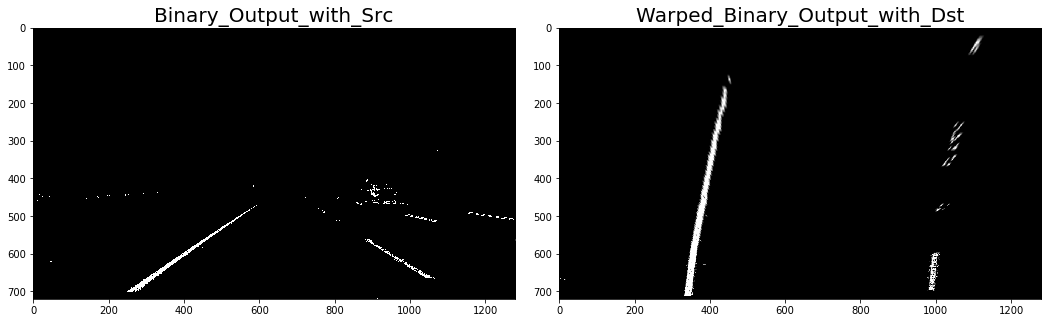

In [17]:
combined_copy = np.copy(combined)
binary_warped_copy = np.copy(binary_warped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
f.tight_layout()
ax1.imshow(combined_copy,cmap='gray')
ax1.set_title('Binary_Output_with_Src', fontsize=20)
ax2.imshow(binary_warped_copy,cmap='gray')
ax2.set_title('Warped_Binary_Output_with_Dst', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [19]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds)>minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped,ym_per_pix = 30/720,xm_per_pix=3.7/700):
    # Find our lane pixels first
    left_lane_inds,right_lane_inds,leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return left_fitx, right_fitx, left_fit_cr, right_fit_cr, out_img



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'fit the poly curve to the lanes')

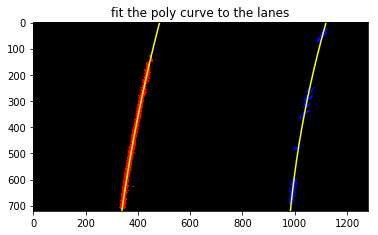

In [21]:
left_fitx, right_fitx, left_fit_cr, right_fit_cr, out_img = fit_polynomial(binary_warped,ym_per_pix = 30/720,xm_per_pix=3.7/700)
plt.imshow(out_img)
plt.title('fit the poly curve to the lanes')

# Step 6 
## Determine the curvature of the lane and vehicle position with respect to center.

In [14]:
def measure_curvature_real(img, left_fit_cr,right_fit_cr,ym_per_pix = 30/720,xm_per_pix=3.7/700):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

In [15]:
xm_per_pix = 3.7/700
curvature = measure_curvature_real(binary_warped,left_fit_cr,right_fit_cr)
car_pos = binary_warped.shape[1]//2
lane_pos = (left_fitx[binary_warped.shape[0]-1] + right_fitx[binary_warped.shape[0]-1])//2
offset = (lane_pos - car_pos)*xm_per_pix # left to lane center offset meter

In [16]:
def show_info(img,curvature,offset):
    cur = (curvature[0]+curvature[1])/2
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,'Radius of Curvature = %dm'%cur,(50,50),font,1,(255,255,255),2)
    if offset>0:
        direction = 'left'
    else:
        direction = 'right'
    cv2.putText(img,'Vehicle is %.2fm %s of center' %(np.abs(offset),direction),(50,100),font,1,(255,255,255),2)

# Step 7
## Warp the detected lane boundaries back onto the original image.

In [17]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0]) 
def draw_lines(undist,warped,ploty,left_fitx,right_fitx,M_inv,curvature,offset):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.4, 0)
    return result
    



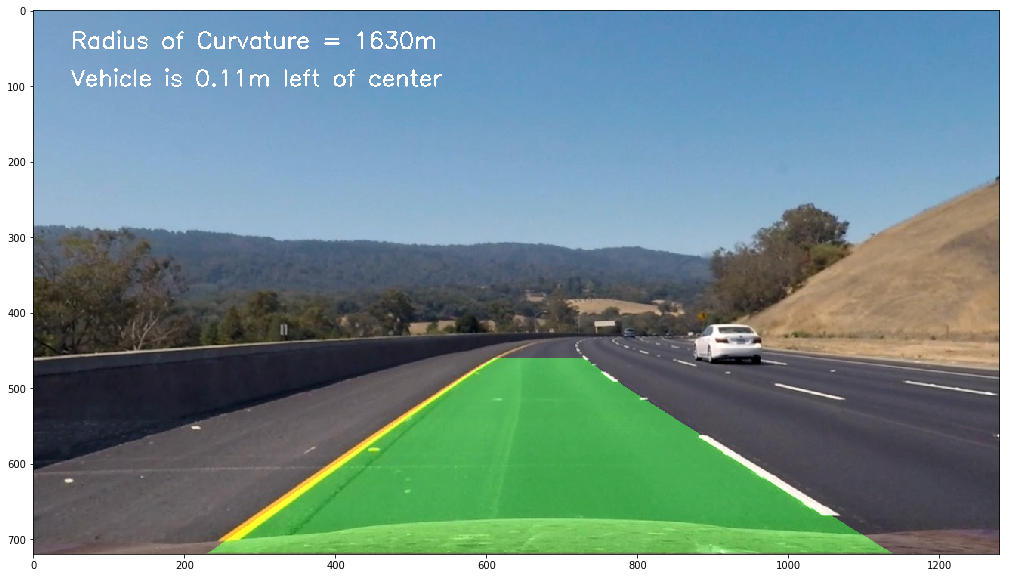

In [18]:
result = draw_lines(undistort2,binary_warped,ploty,left_fitx,right_fitx,perspective_M_inv,curvature,offset)
show_info(result,curvature,offset)
plt.figure(figsize=(20,10))
plt.imshow(result)

# Step 8
## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [19]:
mtx,dist = dist_pickle["mtx"],dist_pickle["dist"]
ym_per_pix = 30/720
xm_per_pix =3.7/700
image = cv2.imread('../test_images/test3.jpg')
img_size = (image.shape[1],image.shape[0])

src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 40, img_size[1]],
    [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

In [20]:
def processing(image,mtx,dist,src,dst,ym_per_pix,xm_per_pix):
    # get undistorted image
    #image = cv2
    undistorted = cal_undistort(image, mtx, dist)
    # get binary output image
    ksize = 3
    gradx = abs_sobel_thresh(undistorted, 'x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(undistorted, 'y', sobel_kernel=ksize, thresh=(120, 200))
    dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0, 1.5))
    color_binary = color(undistorted,s_thresh=(160,255))
    binary = np.zeros_like(dir_binary)
    binary[((gradx == 1) & (grady == 1)) | ((color_binary == 1) & (dir_binary == 1))] = 1
    # get binary_unwarped image
    unwarped, perspective_M, perspective_M_inv = corners_unwarp(image, src, dst)
    # get binary_warped image
    warped = cv2.warpPerspective(binary, perspective_M, (binary.shape[1],binary.shape[0]), flags=cv2.INTER_LINEAR)
    
    left_fitx, right_fitx, left_fit_cr, right_fit_cr, out_img = fit_polynomial(warped,ym_per_pix,xm_per_pix)
    curvature = measure_curvature_real(warped,left_fit_cr,right_fit_cr)
    car_pos = warped.shape[1]//2
    lane_pos = (left_fitx[warped.shape[0]-1] + right_fitx[warped.shape[0]-1])//2
    offset = (lane_pos - car_pos)*xm_per_pix # left to lane center offset meter
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    result = draw_lines(undistorted, warped, ploty,left_fitx, right_fitx, perspective_M_inv, curvature, offset)
    return result,curvature,offset
    

In [21]:
import os
os.listdir("../test_images")



['test6.jpg',
 'test5.jpg',
 'test4.jpg',
 'test1.jpg',
 'test3.jpg',
 'test2.jpg',
 'straight_lines2.jpg',
 'straight_lines1.jpg']

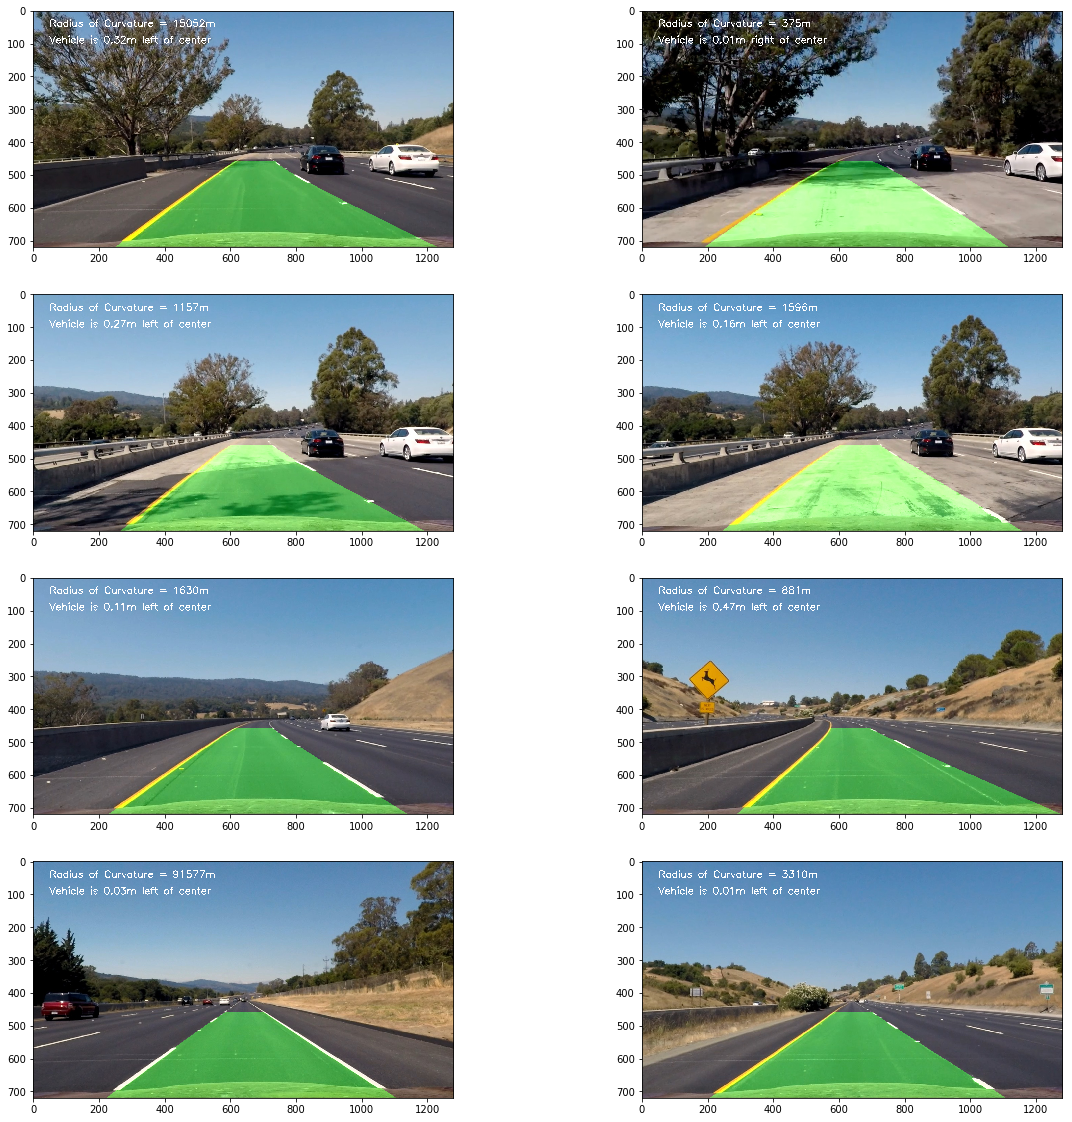

In [22]:
plt.figure(figsize=(20,20))
i = 1
for name in os.listdir("../test_images/"):
    image_path = ('../test_images/'+name)
    image = cv2.imread(image_path)
    #print(image.shape)
    output,curvature,offset = processing(image,mtx,dist,src,dst,ym_per_pix,xm_per_pix)
    show_info(output,curvature,offset)
    plt.imsave('../output_images/'+name, output)
    plt.subplot(4,2,i)
    plt.imshow(output)
    i += 1
plt.show()

In [23]:
def process_image(image):
    output,curvature,offset = processing(image,mtx,dist,src,dst,ym_per_pix,xm_per_pix)
    result = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
    show_info(result,curvature,offset)
    return result

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [26]:
white_output = '../output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4").subclip(0,30)
white_clip = clip1.fl_image(lambda clip:process_image(clip)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../output_videos/project_video.mp4
[MoviePy] Writing video ../output_videos/project_video.mp4


100%|█████████▉| 750/751 [01:46<00:00,  6.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/project_video.mp4 

CPU times: user 2min 14s, sys: 13.7 s, total: 2min 27s
Wall time: 1min 47s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Final Step
## Compact the whole code and Optimize the pipeline

In [28]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        #self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        #self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        #self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None  
        #radius of curvature of the line in some units
        #self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        #self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        #
        self.fitx = None
        #
        self.fit_cr = None
        #
        self.lane_inds = None
        
        

In [29]:
class Image_Processing():
    def __init__(self):
        pass
    
    def gaussianBlur(self,image,kernel_size):
        # input : image with BGR three channels
        # output: image with BGR three channels, after blur processing
        return cv2.GaussianBlur(image,(kernel_size,kernel_size),0)
    
    def cal_undistort(self,image, mtx, dist):
        # input: BGR
        # output : after correction
        undist = cv2.undistort(image,mtx,dist,None,mtx)
        return undist

    def region_of_interest(self, img, vertices):
        #defining a blank mask to start with
        mask = np.zeros_like(img)   
        
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
            
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)
        
        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def abs_sobel_thresh(self, img, orient, sobel_kernel = 3, thresh=(0,255)):
        img = np.copy(img)
        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        if orient == 'x':
        # Sobel x
            sobel = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel) # Take the derivative in x
        else:
        # Sobel y
            sobel = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel) # Take the derivative in y    
        abs_sobel = np.absolute(sobel) # Absolute x/y derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return binary_output


    def dir_threshold(self, img,sobel_kernel=3,thresh = (0,np.pi/2)):
        img = np.copy(img)
        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        sobelx = cv2.Sobel(l_channel,cv2.CV_64F,1,0,ksize=sobel_kernel)
        sobely = cv2.Sobel(l_channel,cv2.CV_64F,0,1,ksize=sobel_kernel)   
        direction = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
        binary_output = np.zeros_like(direction)
        binary_output[(direction>=thresh[0])&(direction<=thresh[1])] = 1
        return binary_output 

    def color(self, img, s_thresh=(170,255)):
        img = np.copy(img)
        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel>=s_thresh[0])&(s_channel<=s_thresh[1])]=1
        return s_binary

    def corners_unwarp(self, img, src, dst):
        #gray = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img_size = (img.shape[1],img.shape[0])
        M = cv2.getPerspectiveTransform(src, dst)
        M_inv = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        return warped, M, M_inv

In [30]:
def search_around_poly(binary_warped,left_line,right_line,ym_per_pix,xm_per_pix):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    thresh = 1000000
    pix_diff = 1000
    # Grab activated pixels

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    if left_line.detected:
        left_lane_inds = ((nonzerox > (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + 
            left_line.current_fit[2] - margin)) & (nonzerox < (left_line.current_fit[0]*(nonzeroy**2) + 
            left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] + margin))).nonzero()[0]
        if abs(len(left_lane_inds)-len(left_line.lane_inds)) > pix_diff:
            pass
        else:
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            left_fit = np.polyfit(lefty, leftx, 2)
            left_line.diffs = abs(np.sum(left_fit - left_line.current_fit))
            if left_line.diffs > thresh:
                pass
            else:
                try:
                    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
                    left_line.fitx = left_fitx
                    left_line.allx = leftx
                    left_line.ally = lefty
                    left_line.current_fit = left_fit
                    left_line.lane_inds = left_lane_inds
                except TypeError:
                    print('The function failed to fit left line!')
                    left_fitx = 1*ploty**2+1*ploty
    else:
        left_lane_inds,right_lane_inds,leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        left_line.fitx = left_fitx
        left_line.ally = lefty
        left_line.allx = leftx
        left_line.current_fit = left_fit
        left_line.lane_inds = np.array(left_lane_inds)
        left_line.detected = True


    if right_line.detected:
        right_lane_inds = ((nonzerox > (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + 
                    right_line.current_fit[2] - margin)) & (nonzerox < (right_line.current_fit[0]*(nonzeroy**2) + 
                    right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] + margin))).nonzero()[0]
        if abs(len(right_lane_inds) - len(right_line.lane_inds)) > pix_diff:
            pass
        else:
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            right_fit = np.polyfit(righty, rightx, 2)
            right_line.diffs = abs(np.sum(right_fit - right_line.current_fit))
            if right_line.diffs > thresh:
                pass
            else:
                try:
                    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
                    right_line.fitx = right_fitx
                    right_line.allx = rightx
                    right_line.ally = righty
                    right_line.current_fit = right_fit
                    right_line.lane_inds = right_lane_inds
                except TypeError:
                    print('The function failed to fit right line!') 
                    right_fitx = 1*ploty**2+1*ploty
    else:
        left_lane_inds,right_lane_inds,leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        right_line.fitx = right_fitx
        right_line.allx = rightx
        right_line.ally = righty
        right_line.current_fit = right_fit
        right_line.lane_inds = np.array(right_lane_inds)
        right_line.detected = True


    left_fit_cr = np.polyfit(left_line.ally*ym_per_pix, left_line.allx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_line.ally*ym_per_pix, right_line.allx*xm_per_pix, 2)
    left_line.fit_cr = left_fit_cr
    right_line.fit_cr = right_fit_cr
    
    return left_line,right_line,result

In [31]:
t = Image_Processing()
left_line,right_line = Line(),Line()
# parameters to be tuned:
image = cv2.imread('../test_images/test3.jpg')
kernel_size = 5 #blur 
mtx,dist = dist_pickle["mtx"],dist_pickle["dist"] # initial parameters of camera
vertices = np.array([[(0,imshape[0]),(int(0.45*imshape[1]),int(0.6*imshape[0])),
                      (int(0.6*imshape[1]),int(0.6*imshape[0])), (imshape[1],imshape[0])]], dtype=np.int32) 
            # region of the image
sobel_kernel_x,sobel_kernel_y = 3,3 # the parameters of sobel
dir_kernel,dir_thresh = 15,(0,255) # the parameters of dir_sobel
s_thresh = (170,255) # the parameters of color
# below parameters src and dst represents the matrix, which helps us get the bird view image
src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 40, img_size[1]],
    [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

ym_per_pix = 30/720
xm_per_pix =3.7/700

In [32]:
def pipeline(image):
    global left_line,right_line
    blur = t.gaussianBlur(image,kernel_size)
    undistorted = t.cal_undistort(blur,mtx,dist)
    gradx = t.abs_sobel_thresh(undistorted, 'x', sobel_kernel = sobel_kernel_x, thresh=(20, 100))
    grady = t.abs_sobel_thresh(undistorted, 'y', sobel_kernel = sobel_kernel_y, thresh=(120, 200))
    dir_binary = t.dir_threshold(undistorted, sobel_kernel=dir_kernel, thresh=(0, 1.5))
    color_binary = t.color(undistorted,s_thresh=(160,255))
    binary = np.zeros_like(dir_binary)
    binary[((gradx == 1) & (grady == 1)) | ((color_binary == 1) & (dir_binary == 1))] = 1
    unwarped, perspective_M, perspective_M_inv = t.corners_unwarp(image, src, dst)
    binary_warped = cv2.warpPerspective(binary, perspective_M, (binary.shape[1],binary.shape[0]), flags=cv2.INTER_LINEAR)
    left_line,right_line,result = search_around_poly(binary_warped,left_line,right_line,ym_per_pix,xm_per_pix)
    curvature = measure_curvature_real(binary_warped,left_line.fit_cr,right_line.fit_cr)
    car_pos = binary_warped.shape[1]//2
    lane_pos = (left_line.fitx[binary_warped.shape[0]-1] + right_line.fitx[binary_warped.shape[0]-1])//2
    offset = (lane_pos - car_pos)*xm_per_pix # left to lane center offset meter
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    result = draw_lines(undistorted, binary_warped, ploty,left_line.fitx, right_line.fitx, perspective_M_inv, curvature, offset)
    show_info(result,curvature,offset)
    return result

In [33]:
white_output = '../output_videos/project_video_opt.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4").subclip(0,30)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video ../output_videos/project_video_opt.mp4
[MoviePy] Writing video ../output_videos/project_video_opt.mp4


100%|█████████▉| 750/751 [01:38<00:00,  7.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/project_video_opt.mp4 

CPU times: user 2min 8s, sys: 12 s, total: 2min 20s
Wall time: 1min 39s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))